In [1]:
from glob import iglob
from pathlib import Path

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import cv2

from matplotlib import pyplot as plt

from tqdm import tqdm
import albumentations as A

import seaborn as sns

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [5]:
ls ../data

bkai_polyp/    cityscapes_binarized@  dfu/           phrasecut@
busi/          clinicdb_polyp/        etis_polyp/    VOC2012_binarized@
camus/         colondb_polyp/         isic/
chexlocalize/  cvc300_polyp/          kvasir_polyp/


In [7]:
datasets = (
    'bkai_polyp',
    'busi',
    "camus",
    'chexlocalize',
    'clinicdb_polyp',
    'colondb_polyp',
    'cvc300_polyp',
    'dfu',
    'etis_polyp',
    'isic',
    'kvasir_polyp',
    "phrasecut",
    "cityscapes_binarized",
    "VOC2012_binarized",
)
len(datasets)

14

In [8]:
class ImageDirDataset(Dataset):
    def __init__(self, glob_pattern, transforms=None):
        if isinstance(glob_pattern, str):
            glob_pattern = (glob_pattern,)

        self.image_paths = []
        for pat in glob_pattern:
            self.image_paths.extend(
                p for p in iglob(pat, recursive=True)
                if "test/" not in p and "validation/" not in p
            )

        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        image = self.load_image(image_path)

        if self.transforms is None:
            return image

        return self.transforms(image=image)["image"]

    @staticmethod
    def load_image(path):
        img = cv2.imread(str(path), cv2.IMREAD_COLOR)

        if img is None:
            msg = f"Image not found in the path: {path}"
            raise ValueError(msg)

        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [9]:
ds = ImageDirDataset(["../data/**/images/**/*.png", "../data/**/images/**/*.jpg"])
len(ds)

92530

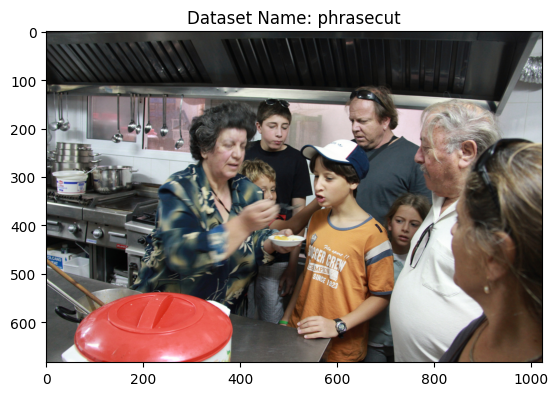

In [16]:
from random import randrange

rand_idx = randrange(len(ds))

img = ds[rand_idx]
ds_name = ds.image_paths[rand_idx]

plt.imshow(img)
plt.title(f"Dataset Name: {ds_name.split('/', 3)[2]}");

In [17]:
unique_parents = set(p.rsplit("/", 1)[0] for p in ds.image_paths)
unique_parents

{'../data/VOC2012_binarized/images/training',
 '../data/bkai_polyp/images',
 '../data/busi/images',
 '../data/camus/images/train',
 '../data/chexlocalize/images',
 '../data/cityscapes_binarized/images/training',
 '../data/clinicdb_polyp/images',
 '../data/colondb_polyp/images',
 '../data/cvc300_polyp/images',
 '../data/dfu/images',
 '../data/etis_polyp/images',
 '../data/isic/images',
 '../data/kvasir_polyp/images',
 '../data/phrasecut/images'}

In [18]:
assert len(datasets) == len(unique_parents), "Parents and total datasets mismatch!"

In [46]:
ds_indices = {}
for idx, path in enumerate(ds.image_paths):
    curr_ds = path.split("/", 3)[2]

    indices = ds_indices.get(curr_ds)

    if indices is None:
        ds_indices[curr_ds] = [idx]
    else:
        indices.append(idx)

In [47]:
compressed_ds_indices = {}

for curr_ds, indices in ds_indices.items():
    min_idx = indices[0]
    max_idx = indices[-1]

    if (max_idx - min_idx == len(indices) - 1):
        compressed_ds_indices[curr_ds] = (min_idx, max_idx+1)
compressed_ds_indices

{'busi': (0, 780),
 'camus': (780, 2580),
 'colondb_polyp': (2580, 2960),
 'cityscapes_binarized': (2960, 5935),
 'etis_polyp': (5935, 6131),
 'phrasecut': (6131, 84213),
 'clinicdb_polyp': (84213, 84825),
 'VOC2012_binarized': (84825, 86289),
 'cvc300_polyp': (86289, 86349),
 'bkai_polyp': (86349, 87349),
 'chexlocalize': (87349, 88251),
 'kvasir_polyp': (88251, 89251),
 'dfu': (89251, 91251),
 'isic': (91251, 92530)}

In [48]:
assert len(compressed_ds_indices) == len(ds_indices)

In [49]:
del ds_indices

In [36]:
# dataloader = DataLoader(ds, batch_size=1, shuffle=False, num_workers=4, prefetch_factor=8)

Comparing the shift in mean and std of images

CLIP's mean and std:

```
img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]
```

In [50]:
# img_means = torch.empty(len(ds), 3)
# img_stds = torch.empty(len(ds), 3)

# with tqdm(dataloader) as pbar:
#     for idx, img in enumerate(pbar):
#         img = img.view(-1, 3).float() / 255
#         img_means[idx] = img.mean(0)
#         img_stds[idx] = img.std(0, correction=0)
        
#         if idx % 100 == 0:
#             pbar.set_postfix({
#                 "mean": torch.mean(img_means[:idx+1], 0),
#                 "std": torch.std(img_stds[:idx+1], 0, correction=0)
#             })
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 14448/14448 [27:52<00:00,  8.64it/s, mean=tensor([0.4428, 0.3913, 0.3532]), std=tensor([0.0757, 0.0552, 0.0570])]


In [60]:
# ds_mean_std = {}
# for curr_ds, (id_min, idx_max) in compressed_ds_indices.items():    
#     ds_mean_std[curr_ds] = (
#         img_means[id_min: idx_max + 1].mean(0),
#         img_stds[id_min: idx_max + 1].std(0, correction=0)
#     )
# ds_mean_std["total"] = (
#         img_means.mean(0),
#         img_stds.std(0, correction=0)
#     )
# ds_mean_std

{'busi': (tensor([0.3280, 0.3280, 0.3279]), tensor([0.0359, 0.0359, 0.0359])),
 'camus': (tensor([0.1915, 0.1915, 0.1915]), tensor([0.0436, 0.0436, 0.0436])),
 'colondb_polyp': (tensor([0.4412, 0.2870, 0.1878]),
  tensor([0.0417, 0.0398, 0.0414])),
 'cityscapes_binarized': (tensor([0.2869, 0.3251, 0.2839]),
  tensor([0.0421, 0.0405, 0.0425])),
 'etis_polyp': (tensor([0.6015, 0.4312, 0.3723]),
  tensor([0.0400, 0.0441, 0.0418])),
 'clinicdb_polyp': (tensor([0.4008, 0.2694, 0.1841]),
  tensor([0.0441, 0.0325, 0.0285])),
 'VOC2012_binarized': (tensor([0.4568, 0.4431, 0.4083]),
  tensor([0.0595, 0.0595, 0.0664])),
 'cvc300_polyp': (tensor([0.4598, 0.3045, 0.2430]),
  tensor([0.0256, 0.0267, 0.0344])),
 'bkai_polyp': (tensor([0.5419, 0.3580, 0.2815]),
  tensor([0.0292, 0.0309, 0.0320])),
 'chexlocalize': (tensor([0.5025, 0.5025, 0.5025]),
  tensor([0.0078, 0.0078, 0.0078])),
 'kvasir_polyp': (tensor([0.5571, 0.3217, 0.2358]),
  tensor([0.0338, 0.0327, 0.0366])),
 'dfu': (tensor([0.6262, 0.5

```json
{'busi': (tensor([0.3280, 0.3280, 0.3279]), tensor([0.0359, 0.0359, 0.0359])),
 'camus': (tensor([0.1915, 0.1915, 0.1915]), tensor([0.0436, 0.0436, 0.0436])),
 'colondb_polyp': (tensor([0.4412, 0.2870, 0.1878]),
  tensor([0.0417, 0.0398, 0.0414])),
 'cityscapes_binarized': (tensor([0.2869, 0.3251, 0.2839]),
  tensor([0.0421, 0.0405, 0.0425])),
 'etis_polyp': (tensor([0.6015, 0.4312, 0.3723]),
  tensor([0.0400, 0.0441, 0.0418])),
 'clinicdb_polyp': (tensor([0.4008, 0.2694, 0.1841]),
  tensor([0.0441, 0.0325, 0.0285])),
 'VOC2012_binarized': (tensor([0.4568, 0.4431, 0.4083]),
  tensor([0.0595, 0.0595, 0.0664])),
 'cvc300_polyp': (tensor([0.4598, 0.3045, 0.2430]),
  tensor([0.0256, 0.0267, 0.0344])),
 'bkai_polyp': (tensor([0.5419, 0.3580, 0.2815]),
  tensor([0.0292, 0.0309, 0.0320])),
 'chexlocalize': (tensor([0.5025, 0.5025, 0.5025]),
  tensor([0.0078, 0.0078, 0.0078])),
 'kvasir_polyp': (tensor([0.5571, 0.3217, 0.2358]),
  tensor([0.0338, 0.0327, 0.0366])),
 'dfu': (tensor([0.6262, 0.5736, 0.5511]), tensor([0.0510, 0.0389, 0.0406])),
 'isic': (tensor([0.7239, 0.6195, 0.5681]), tensor([0.0624, 0.0576, 0.0591])),
 'total': (tensor([0.4438, 0.3921, 0.3539]), tensor([0.0759, 0.0553, 0.0570]))}
```

In [50]:
open_domain_datasets = ("phrasecut", "cityscapes_binarized", "VOC2012_binarized")

open_domain_indices = {k: compressed_ds_indices[k] for k in open_domain_datasets}
open_domain_indices

{'phrasecut': (6131, 84213),
 'cityscapes_binarized': (2960, 5935),
 'VOC2012_binarized': (84825, 86289)}

In [51]:
medical_domain_indices = {k: v for k, v in compressed_ds_indices.items() if k not in open_domain_datasets}
medical_domain_indices

{'busi': (0, 780),
 'camus': (780, 2580),
 'colondb_polyp': (2580, 2960),
 'etis_polyp': (5935, 6131),
 'clinicdb_polyp': (84213, 84825),
 'cvc300_polyp': (86289, 86349),
 'bkai_polyp': (86349, 87349),
 'chexlocalize': (87349, 88251),
 'kvasir_polyp': (88251, 89251),
 'dfu': (89251, 91251),
 'isic': (91251, 92530)}

In [61]:
def process_ds_name(ds_name):
    return ds_name.removesuffix("polyp").removesuffix("binarized").replace("_", " ").rstrip().title()
process_ds_name("cityscapes_binarized")

'Cityscapes'

In [62]:
all_ds_indices = {process_ds_name(k): v for k, v in {**medical_domain_indices, **open_domain_indices}.items()}
all_ds_indices

{'Busi': (0, 780),
 'Camus': (780, 2580),
 'Colondb': (2580, 2960),
 'Etis': (5935, 6131),
 'Clinicdb': (84213, 84825),
 'Cvc300': (86289, 86349),
 'Bkai': (86349, 87349),
 'Chexlocalize': (87349, 88251),
 'Kvasir': (88251, 89251),
 'Dfu': (89251, 91251),
 'Isic': (91251, 92530),
 'Phrasecut': (6131, 84213),
 'Cityscapes': (2960, 5935),
 'Voc2012': (84825, 86289)}

In [63]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device=}")

Using device='cuda'


In [64]:
from transformers import CLIPVisionModelWithProjection

model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32").eval().to(device)

In [65]:
import math

BATCH_SIZE = 256
num_iter = math.ceil(len(ds) / BATCH_SIZE)
num_iter

362

In [66]:
from albumentations.pytorch import ToTensorV2

img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]

transforms = A.Compose((
    A.Resize(height=224, width=224, interpolation=cv2.INTER_CUBIC),
    A.Normalize(mean=img_mean, std=img_std),
    ToTensorV2()
))
transforms

Compose([
  Resize(always_apply=False, p=1.0, height=224, width=224, interpolation=2),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

In [67]:
ds = ImageDirDataset(["../data/**/images/**/*.png", "../data/**/images/**/*.jpg"], transforms=transforms)
dataloader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, prefetch_factor=4)

In [68]:
import gc

torch.cuda.empty_cache()
gc.collect()

531

In [69]:
all_embeds = np.empty((len(ds), model.config.projection_dim), dtype=np.float32)
all_embeds.shape

(92530, 512)

In [70]:
from tqdm import tqdm

with torch.inference_mode():
    for idx, batch in enumerate(tqdm(dataloader)):
        batch = batch.to(device)
        image_embeds = model(batch).image_embeds.cpu().numpy()

        start_idx = idx * BATCH_SIZE
        all_embeds[start_idx: start_idx + BATCH_SIZE] = image_embeds

100%|████████████████████████████████████████████████████████████████████| 362/362 [04:16<00:00,  1.41it/s]


In [72]:
np.save("all_image_embeds.npy", all_embeds)

In [73]:
del batch
del image_embeds
del model

In [71]:
import gc

torch.cuda.empty_cache()
gc.collect()

0

In [23]:
# all_embeds = np.load("all_image_embeds.npy")
# all_embeds.shape

(14448, 512)

In [74]:
pca = PCA()
pca_transformed = pca.fit_transform(all_embeds)
pca_transformed.shape

(92530, 512)

In [75]:
def plot_explained_variance_ratio(explained_variance_ratio):
    plt.plot(explained_variance_ratio)
    plt.ylabel(f"Explained Variance Ratio with total: {explained_variance_ratio.sum():.4f}")
    plt.xlabel("Num of components")

In [76]:
pca.explained_variance_[:10]

array([4.70261925, 2.9125048 , 2.79305103, 2.18571931, 1.65919114,
       1.51291875, 1.31393232, 1.16196873, 1.0696942 , 1.00000599])

In [77]:
pca.explained_variance_ratio_[:10]

array([0.0805818 , 0.04990727, 0.04786036, 0.03745342, 0.02843109,
       0.02592464, 0.02251491, 0.01991093, 0.01832976, 0.01713562])

In [78]:
pca.explained_variance_ratio_[:2].sum()

0.13048906431386503

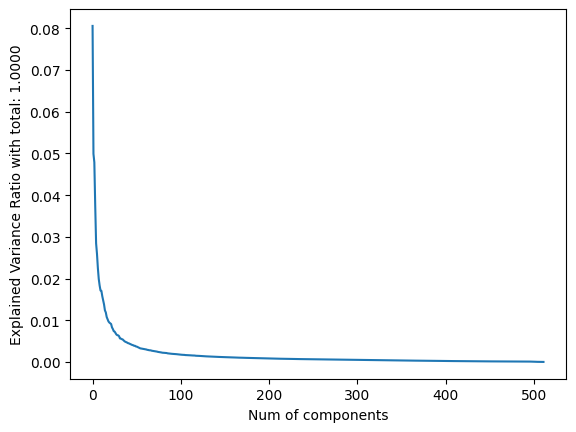

In [79]:
plot_explained_variance_ratio(pca.explained_variance_ratio_)

In [80]:
palette = sns.color_palette("hls", len(all_ds_indices))

def plot_2d_components(transformed_points, ax=None, first_component=0, second_component=1):
    for (label, (min_idx, max_idx)), color in zip(all_ds_indices.items(), palette):
        sns.scatterplot(
            x=transformed_points[min_idx: max_idx + 1, first_component],
            y=transformed_points[min_idx: max_idx + 1, second_component],
            label=label,
            linewidth=0.2,
            color=color,
            ax=ax
        )
    
    # xlabel = f"Principal component: {first_component}"
    # ylabel = f"Principal component: {second_component}"
    # if ax is None:
    #     plt.xlabel(xlabel)
    #     plt.ylabel(ylabel)
    # else:
    #     ax.set_xlabel(xlabel)
    #     ax.set_ylabel(ylabel)

def plot_principal_components(transformed_points, n_rows=2, n_cols=3, figsize=(9, 6), legend_loc="best"):
    if n_rows == 1 and n_cols == 1:
        plot_2d_components(transformed_points)
    else:
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

        for i, ax in enumerate(axes.flatten()):
            plot_2d_components(transformed_points, ax, first_component=i, second_component=i + 1)
    plt.axis('off')
    plt.legend(bbox_to_anchor=(1, 0.5), loc=legend_loc)
    plt.tight_layout()

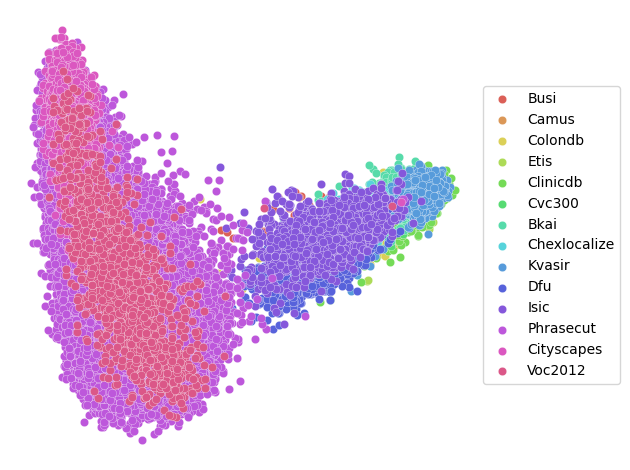

In [81]:
plot_principal_components(pca_transformed, 1, 1, legend_loc="center left")

In [82]:
import gc

torch.cuda.empty_cache()
gc.collect()

6032

In [91]:
all_ds_indices

{'Busi': (0, 780),
 'Camus': (780, 2580),
 'Colondb': (2580, 2960),
 'Etis': (5935, 6131),
 'Clinicdb': (84213, 84825),
 'Cvc300': (86289, 86349),
 'Bkai': (86349, 87349),
 'Chexlocalize': (87349, 88251),
 'Kvasir': (88251, 89251),
 'Dfu': (89251, 91251),
 'Isic': (91251, 92530),
 'Phrasecut': (6131, 84213),
 'Cityscapes': (2960, 5935),
 'Voc2012': (84825, 86289)}

In [92]:
max(map(len, all_ds_indices))

12

In [93]:
labels = np.empty(len(all_embeds), dtype="<U12")

for ds_name, (min_idx, max_idx) in all_ds_indices.items():
    labels[min_idx: max_idx] = ds_name

In [94]:
labels

array(['Busi', 'Busi', 'Busi', ..., 'Isic', 'Isic', 'Isic'], dtype='<U12')

In [95]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda_transformed = lda.fit_transform(all_embeds, labels)
lda_transformed.shape

(92530, 13)

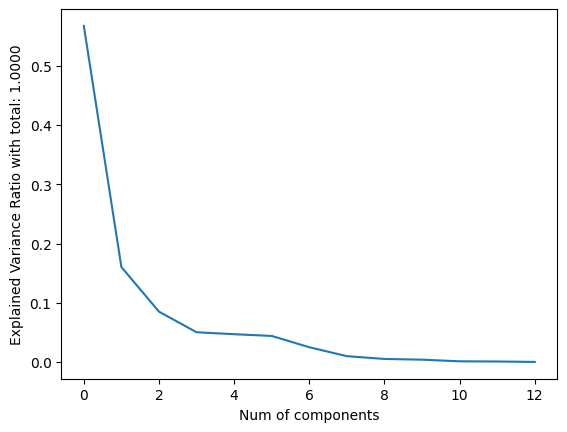

In [96]:
plot_explained_variance_ratio(lda.explained_variance_ratio_)

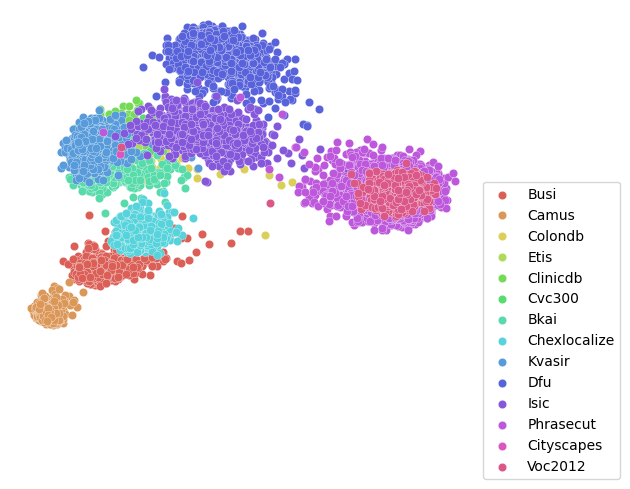

In [97]:
plot_principal_components(lda_transformed, 1, 1)

In [ ]:
import gc

torch.cuda.empty_cache()
gc.collect()

In [83]:
tsne = TSNE(n_components=2, perplexity=50, n_jobs=-1)
tsne_transformed = tsne.fit_transform(all_embeds)
tsne_transformed.shape, tsne.kl_divergence_

((92530, 2), 2.674368143081665)

In [84]:
tsne_transformed_variance = tsne_transformed.var(axis=0)
tsne_transformed_variance

array([2285.3372, 2070.0469], dtype=float32)

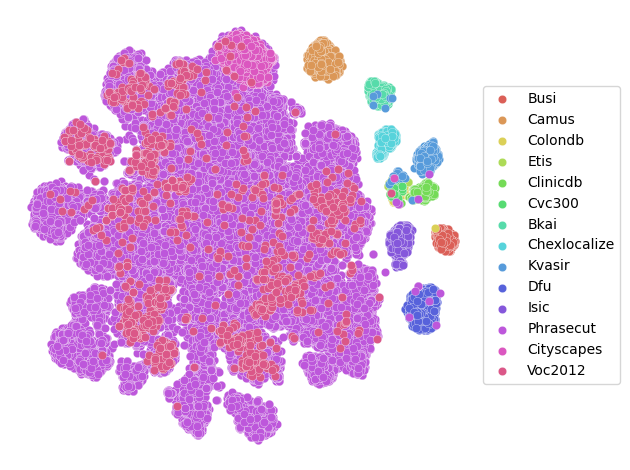

In [85]:
plot_principal_components(tsne_transformed, 1, 1, legend_loc="center left")

In [86]:
pca_tsne = TSNE(n_components=2, perplexity=50, n_jobs=-1)
pca_tsne_transformed = pca_tsne.fit_transform(pca_transformed[:, :100])
pca_tsne_transformed.shape, pca_tsne.kl_divergence_

((92530, 2), 2.673588991165161)

In [87]:
pca_tsne_transformed_variance = pca_tsne_transformed.var(axis=0)
pca_tsne_transformed_variance

array([2355.672 , 2140.3833], dtype=float32)

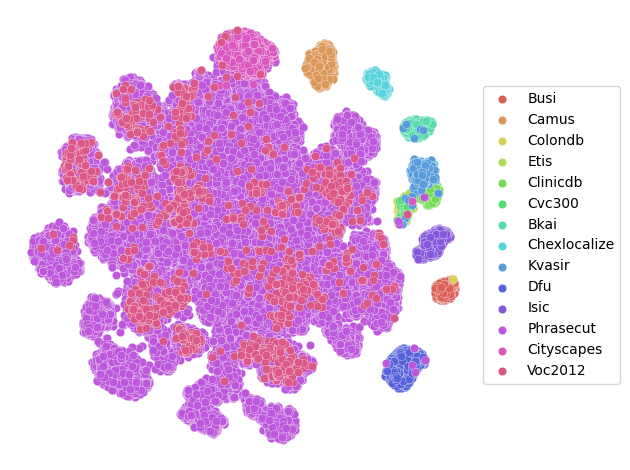

In [88]:
plot_principal_components(pca_tsne_transformed, 1, 1, legend_loc="center left")